# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

# Load Things

In [3]:
trainX_first = np.load('outputs/train_x_first.npy')
trainY_first = np.load('outputs/train_y_first.npy')

trainX_second = np.load('outputs/train_x_second.npy')
trainY_second = np.load('outputs/train_y_second.npy')

In [4]:
df_first = pd.read_csv('dataset/firsthalf.csv')
df_second = pd.read_csv('dataset/secondhalf.csv')

In [5]:
total_samples_first = trainX_first.shape[0]
split_index_first = int(total_samples_first * 0.9)

total_samples_second = trainX_second.shape[0]
split_index_second = int(total_samples_second * 0.9)

In [6]:
n_future = 1   # Number of data we want to look into the future based on the past data.
n_past = 24  # Number of past data we want to use to predict the future.

In [7]:
true_value_first = df_first['traffic_volume'][split_index_first+n_past:].values
true_value_second = df_second['traffic_volume'][split_index_second+n_past:].values

In [8]:
import joblib
scaler_first = joblib.load('outputs/MM_scaler_first.joblib')
scaler_second = joblib.load('outputs/MM_scaler_second.joblib')

# Train test Split

In [12]:
total_samples_first = trainX_first.shape[0]
split_index_first = int(total_samples_first * 0.9)

X_train_first = trainX_first[:split_index_first]
y_train_first = trainY_first[:split_index_first]
X_test_first = trainX_first[split_index_first:]
y_test_first = trainY_first[split_index_first:]

In [13]:
total_samples_second = trainX_second.shape[0]
split_index_second = int(total_samples_second * 0.9)

X_train_second = trainX_second[:split_index_second]
y_train_second = trainY_second[:split_index_second]
X_test_second = trainX_second[split_index_second:]
y_test_second = trainY_second[split_index_second:]

In [14]:
print(f'X_train_first length == {len(X_train_first)}')
print(f'X_test_first length == {len(X_test_first)}')

print(f'X_train_second length == {len(X_train_second)}')
print(f'X_test_second length == {len(X_test_second)}')

X_train_first length == 14552
X_test_first length == 1617
X_train_second length == 15231
X_test_second length == 1693


# LSTM

## First Half Dataset

In [46]:
def build_model_LSTM_first(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('units_layer1', min_value=32, max_value=128, step=32),
                   activation=hp.Choice('activation', values=['relu', 'tanh']),
                   input_shape=(trainX_first.shape[1], trainX_first.shape[2]),
                   return_sequences=True))
    model.add(LSTM(hp.Int('units_layer2', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(trainY_first.shape[1]))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
                  loss='mae')
    return model

In [47]:
tuner_LSTM = RandomSearch(
    build_model_LSTM_first,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='model/LSTM_first/',
    project_name='LSTM_tuning_first'
)

tuner_LSTM.search(X_train_first, y_train_first, epochs=10, validation_data=(X_test_first, y_test_first))

Trial 10 Complete [00h 04m 08s]
val_loss: 0.04878443976243337

Best val_loss So Far: 0.04561547810832659
Total elapsed time: 00h 55m 08s


In [49]:
# Get the optimal hyperparameters
best_hps_LSTM_first = tuner_LSTM.get_best_hyperparameters(num_trials=1)[0]

for param in best_hps_LSTM_first.values:
    print(param, best_hps_LSTM_first.get(param))

units_layer1 64
activation tanh
units_layer2 64
dropout 0.2
optimizer rmsprop


In [50]:
# Build the model with the best hyperparameters
model_LSTM_tuned_first = tuner_LSTM.hypermodel.build(best_hps_LSTM_first)
history_LSTM_tuned_first = model_LSTM_tuned_first.fit(trainX_first, trainY_first, epochs=50, validation_data=(X_test_first, y_test_first))

Epoch 1/50
506/506 [==============================] - 17s 22ms/step - loss: 0.1353 - val_loss: 0.0965
Epoch 2/50
506/506 [==============================] - 10s 19ms/step - loss: 0.0926 - val_loss: 0.0821
Epoch 3/50
506/506 [==============================] - 10s 19ms/step - loss: 0.0768 - val_loss: 0.0608
Epoch 4/50
506/506 [==============================] - 9s 19ms/step - loss: 0.0646 - val_loss: 0.0486
Epoch 5/50
506/506 [==============================] - 9s 18ms/step - loss: 0.0574 - val_loss: 0.0440
Epoch 6/50
506/506 [==============================] - 9s 17ms/step - loss: 0.0528 - val_loss: 0.0574
Epoch 7/50
506/506 [==============================] - 9s 17ms/step - loss: 0.0503 - val_loss: 0.0513
Epoch 8/50
506/506 [==============================] - 9s 17ms/step - loss: 0.0486 - val_loss: 0.0374
Epoch 9/50
506/506 [==============================] - 9s 17ms/step - loss: 0.0469 - val_loss: 0.0565
Epoch 10/50
506/506 [==============================] - 9s 17ms/step - loss: 0.0456 - val

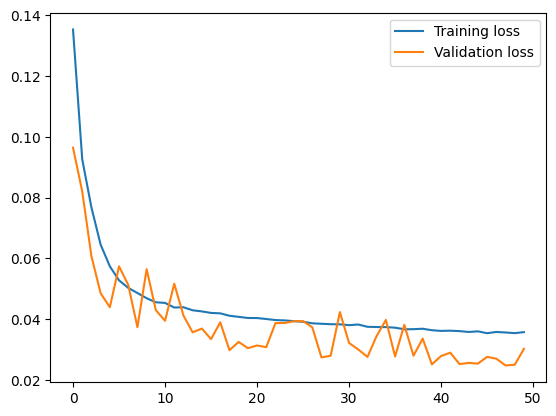

In [51]:
plt.plot(history_LSTM_tuned_first.history['loss'], label='Training loss')
plt.plot(history_LSTM_tuned_first.history['val_loss'], label='Validation loss')
plt.legend()

In [52]:
pred_LSTM_tuned_first = model_LSTM_tuned_first.predict(X_test_first)

51/51 [==============================] - 1s 8ms/step


In [53]:
prediction_copies = np.repeat(pred_LSTM_tuned_first, 70, axis=-1)
pred_LSTM_tuned_unscaled_first = scaler_first.inverse_transform(prediction_copies)[:,-1]

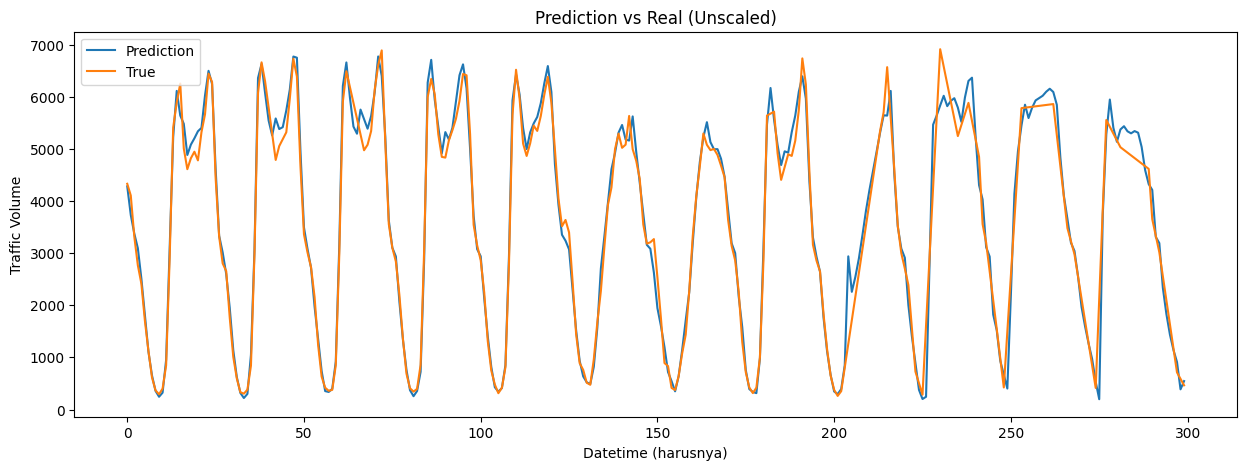

In [54]:
# Plot Prediction vs Real Data
plt.figure(figsize=(15,5))
plt.plot(pred_LSTM_tuned_unscaled_first[:300])
plt.plot(true_value_first[:300])
plt.title('Prediction vs Real (Unscaled)')
plt.xlabel('Datetime (harusnya)')
plt.ylabel('Traffic Volume')
plt.legend(['Prediction','True'], loc='upper left')
plt.show()

In [55]:
from sklearn.metrics import mean_absolute_error

mae_tuned_LSTM = mean_absolute_error(pred_LSTM_tuned_unscaled_first, true_value_first)
print(mae_tuned_LSTM)

214.72098850379544


## Second Half Dataset

In [56]:
def build_model_LSTM_second(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('units_layer1', min_value=32, max_value=128, step=32),
                   activation=hp.Choice('activation', values=['relu', 'tanh']),
                   input_shape=(trainX_second.shape[1], trainX_second.shape[2]),
                   return_sequences=True))
    model.add(LSTM(hp.Int('units_layer2', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(trainY_second.shape[1]))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
                  loss='mae')
    return model

In [58]:
tuner_LSTM_second = RandomSearch(
    build_model_LSTM_second,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='model/LSTM_second/',
    project_name='LSTM_tuning_second'
)

tuner_LSTM_second.search(X_train_second, y_train_second, epochs=10, validation_data=(X_test_second, y_test_second))

Trial 10 Complete [00h 05m 38s]
val_loss: 0.03648784011602402

Best val_loss So Far: 0.032430739452441536
Total elapsed time: 01h 00m 36s


In [59]:
# Get the optimal hyperparameters
best_hps_LSTM_second = tuner_LSTM.get_best_hyperparameters(num_trials=1)[0]

for param in best_hps_LSTM_second.values:
    print(param, best_hps_LSTM_second.get(param))

units_layer1 64
activation tanh
units_layer2 64
dropout 0.2
optimizer rmsprop


In [60]:
# Build the model with the best hyperparameters
model_LSTM_tuned_second = tuner_LSTM.hypermodel.build(best_hps_LSTM_second)
history_LSTM_tuned_second = model_LSTM_tuned_second.fit(trainX_second, trainY_second, epochs=50, validation_data=(X_test_second, y_test_second))

Epoch 1/50
529/529 [==============================] - 15s 22ms/step - loss: 0.1246 - val_loss: 0.0777
Epoch 2/50
529/529 [==============================] - 11s 21ms/step - loss: 0.0874 - val_loss: 0.0623
Epoch 3/50
529/529 [==============================] - 11s 21ms/step - loss: 0.0740 - val_loss: 0.0668
Epoch 4/50
529/529 [==============================] - 11s 21ms/step - loss: 0.0625 - val_loss: 0.0410
Epoch 5/50
529/529 [==============================] - 11s 21ms/step - loss: 0.0546 - val_loss: 0.0436
Epoch 6/50
529/529 [==============================] - 11s 21ms/step - loss: 0.0514 - val_loss: 0.0352
Epoch 7/50
529/529 [==============================] - 11s 21ms/step - loss: 0.0481 - val_loss: 0.0435
Epoch 8/50
529/529 [==============================] - 11s 21ms/step - loss: 0.0470 - val_loss: 0.0488
Epoch 9/50
529/529 [==============================] - 11s 21ms/step - loss: 0.0456 - val_loss: 0.0338
Epoch 10/50
529/529 [==============================] - 11s 21ms/step - loss: 0.044

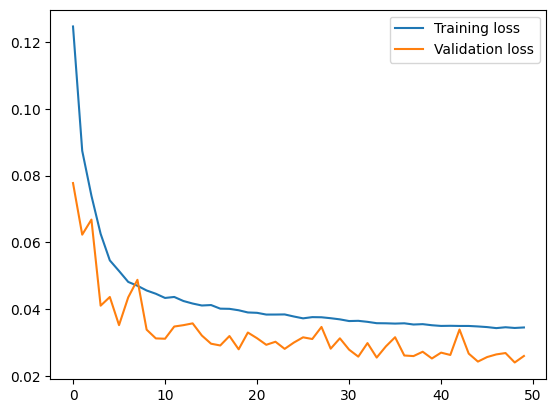

In [61]:
plt.plot(history_LSTM_tuned_second.history['loss'], label='Training loss')
plt.plot(history_LSTM_tuned_second.history['val_loss'], label='Validation loss')
plt.legend()

In [62]:
pred_LSTM_tuned_second = model_LSTM_tuned_second.predict(X_test_second)

53/53 [==============================] - 1s 11ms/step


In [63]:
prediction_copies = np.repeat(pred_LSTM_tuned_second, 70, axis=-1)
pred_LSTM_tuned_unscaled_second = scaler_second.inverse_transform(prediction_copies)[:,-1]

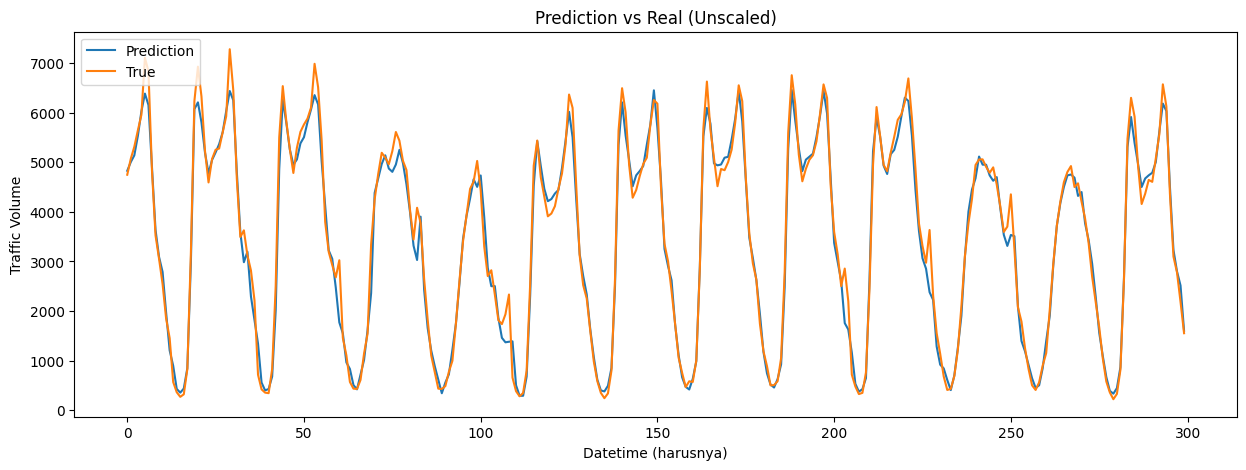

In [64]:
# Plot Prediction vs Real Data
plt.figure(figsize=(15,5))
plt.plot(pred_LSTM_tuned_unscaled_second[:300])
plt.plot(true_value_second[:300])
plt.title('Prediction vs Real (Unscaled)')
plt.xlabel('Datetime (harusnya)')
plt.ylabel('Traffic Volume')
plt.legend(['Prediction','True'], loc='upper left')
plt.show()

In [65]:
from sklearn.metrics import mean_absolute_error

mae_tuned_LSTM_second = mean_absolute_error(pred_LSTM_tuned_unscaled_second, true_value_second)
print(mae_tuned_LSTM_second)

188.84538758441815


# BiLSTM

In [9]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense

## First Half Dataset

In [12]:
from kerastuner.tuners import RandomSearch

def build_model_BiLSTM(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(hp.Int('units_layer1', min_value=32, max_value=128, step=32),
                                activation=hp.Choice('activation', values=['relu', 'tanh']),
                                input_shape=(trainX_first.shape[1], trainX_first.shape[2]),
                                return_sequences=True)))
    model.add(Bidirectional(LSTM(hp.Int('units_layer2', min_value=16, max_value=64, step=16), activation='relu')))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(trainY_first.shape[1]))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
                  loss='mae')
    return model

In [13]:
tuner_BiLSTM = RandomSearch(
    build_model_BiLSTM,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='model/BiLSTM_first',
    project_name='BiLSTM_tuning_first'
)

tuner_BiLSTM.search(X_train_first, y_train_first, epochs=10, validation_data=(X_test_first, y_test_first))

Trial 10 Complete [00h 19m 43s]
val_loss: 0.04882329702377319

Best val_loss So Far: 0.043757239977518715
Total elapsed time: 02h 31m 14s


In [14]:
# Get the optimal hyperparameters
best_hps_BiLSTM_first = tuner_BiLSTM.get_best_hyperparameters(num_trials=1)[0]

for param in best_hps_BiLSTM_first.values:
    print(param, best_hps_BiLSTM_first.get(param))

units_layer1 128
activation tanh
units_layer2 48
dropout 0.1
optimizer rmsprop


In [15]:
# Build the model with the best hyperparameters
model_BiLSTM_tuned_first = tuner_BiLSTM.hypermodel.build(best_hps_BiLSTM_first)
history_BiLSTM_tuned_first = model_BiLSTM_tuned_first.fit(trainX_first, trainY_first, epochs=50, validation_data=(X_test_first, y_test_first))

Epoch 1/50
506/506 [==============================] - 35s 54ms/step - loss: 0.1145 - val_loss: 0.1027
Epoch 2/50
506/506 [==============================] - 27s 53ms/step - loss: 0.0711 - val_loss: 0.0641
Epoch 3/50
506/506 [==============================] - 27s 53ms/step - loss: 0.0577 - val_loss: 0.0585
Epoch 4/50
506/506 [==============================] - 27s 54ms/step - loss: 0.0519 - val_loss: 0.0451
Epoch 5/50
506/506 [==============================] - 27s 54ms/step - loss: 0.0475 - val_loss: 0.0454
Epoch 6/50
506/506 [==============================] - 28s 55ms/step - loss: 0.0456 - val_loss: 0.0726
Epoch 7/50
506/506 [==============================] - 29s 56ms/step - loss: 0.0440 - val_loss: 0.0504
Epoch 8/50
506/506 [==============================] - 30s 59ms/step - loss: 0.0424 - val_loss: 0.0432
Epoch 9/50
506/506 [==============================] - 29s 58ms/step - loss: 0.0417 - val_loss: 0.0376
Epoch 10/50
506/506 [==============================] - 30s 59ms/step - loss: 0.040

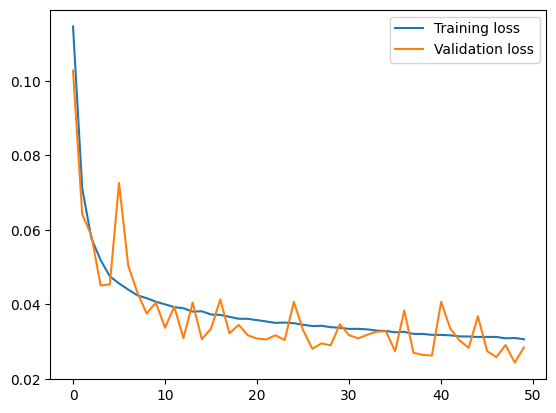

In [17]:
plt.plot(history_BiLSTM_tuned_first.history['loss'], label='Training loss')
plt.plot(history_BiLSTM_tuned_first.history['val_loss'], label='Validation loss')
plt.legend()

In [18]:
pred_BiLSTM_tuned_first = model_BiLSTM_tuned_first.predict(X_test_first)

51/51 [==============================] - 3s 28ms/step


In [20]:
prediction_copies = np.repeat(pred_BiLSTM_tuned_first, 70, axis=-1)
pred_BiLSTM_tuned_unscaled_first = scaler_first.inverse_transform(prediction_copies)[:,-1]

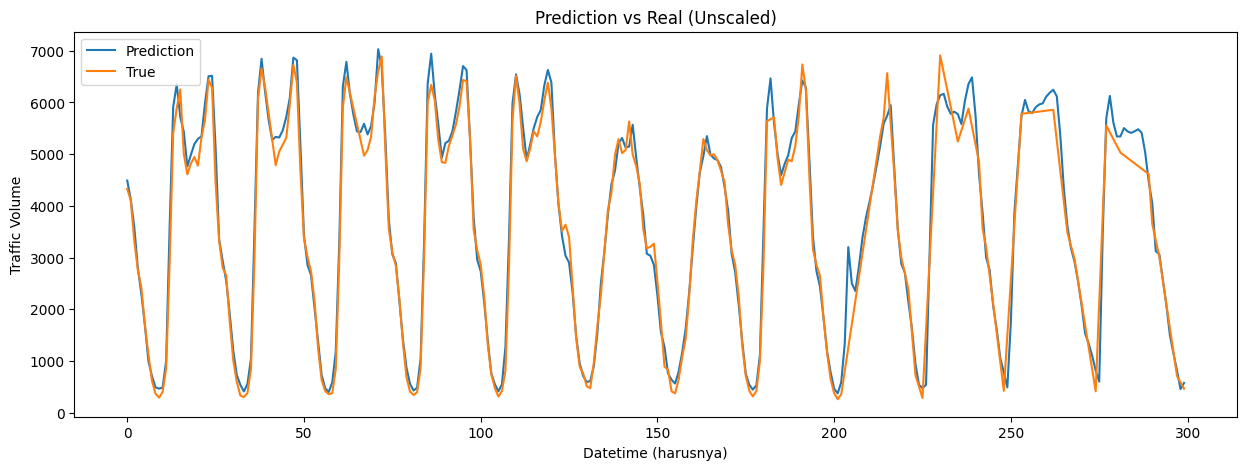

In [25]:
# Plot Prediction vs Real Data
plt.figure(figsize=(15,5))
plt.plot(pred_BiLSTM_tuned_unscaled_first[:300])
plt.plot(true_value_first[:300])
plt.title('Prediction vs Real (Unscaled)')
plt.xlabel('Datetime (harusnya)')
plt.ylabel('Traffic Volume')
plt.legend(['Prediction','True'], loc='upper left')
plt.show()

In [26]:
from sklearn.metrics import mean_absolute_error

mae_tuned_BiLSTM = mean_absolute_error(pred_BiLSTM_tuned_unscaled_first, true_value_first)
print(mae_tuned_BiLSTM)

201.8316538757963


## Second Half Dataset

In [27]:
from kerastuner.tuners import RandomSearch

def build_model_BiLSTM_second(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(hp.Int('units_layer1', min_value=32, max_value=128, step=32),
                                activation=hp.Choice('activation', values=['relu', 'tanh']),
                                input_shape=(trainX_second.shape[1], trainX_second.shape[2]),
                                return_sequences=True)))
    model.add(Bidirectional(LSTM(hp.Int('units_layer2', min_value=16, max_value=64, step=16), activation='relu')))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(trainY_second.shape[1]))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
                  loss='mae')
    return model

In [28]:
tuner_BiLSTM = RandomSearch(
    build_model_BiLSTM,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='model/BiLSTM_second',
    project_name='BiLSTM_tuning_second'
)

tuner_BiLSTM.search(X_train_second, y_train_second, epochs=10, validation_data=(X_test_second, y_test_second))

Trial 10 Complete [00h 07m 44s]
val_loss: 0.03596436480681101

Best val_loss So Far: 0.031977867086728416
Total elapsed time: 01h 58m 25s


In [32]:
# Get the optimal hyperparameters
best_hps_BiLSTM_second = tuner_BiLSTM.get_best_hyperparameters(num_trials=1)[0]

for param in best_hps_BiLSTM_second.values:
    print(param, best_hps_BiLSTM_second.get(param))

units_layer1 32
activation tanh
units_layer2 48
dropout 0.1
optimizer adam


In [33]:
# Build the model with the best hyperparameters
model_BiLSTM_tuned_second = tuner_BiLSTM.hypermodel.build(best_hps_BiLSTM_second)
history_BiLSTM_tuned_second = model_BiLSTM_tuned_second.fit(trainX_second, trainY_second, epochs=50, validation_data=(X_test_second, y_test_second))

Epoch 1/50
529/529 [==============================] - 26s 27ms/step - loss: 0.1092 - val_loss: 0.0698
Epoch 2/50
529/529 [==============================] - 15s 28ms/step - loss: 0.0647 - val_loss: 0.0561
Epoch 3/50
529/529 [==============================] - 14s 27ms/step - loss: 0.0525 - val_loss: 0.0401
Epoch 4/50
529/529 [==============================] - 14s 26ms/step - loss: 0.0467 - val_loss: 0.0369
Epoch 5/50
529/529 [==============================] - 14s 26ms/step - loss: 0.0432 - val_loss: 0.0368
Epoch 6/50
529/529 [==============================] - 17s 31ms/step - loss: 0.0418 - val_loss: 0.0322
Epoch 7/50
529/529 [==============================] - 16s 31ms/step - loss: 0.0399 - val_loss: 0.0318
Epoch 8/50
529/529 [==============================] - 16s 29ms/step - loss: 0.0394 - val_loss: 0.0312
Epoch 9/50
529/529 [==============================] - 16s 31ms/step - loss: 0.0382 - val_loss: 0.0315
Epoch 10/50
529/529 [==============================] - 16s 31ms/step - loss: 0.036

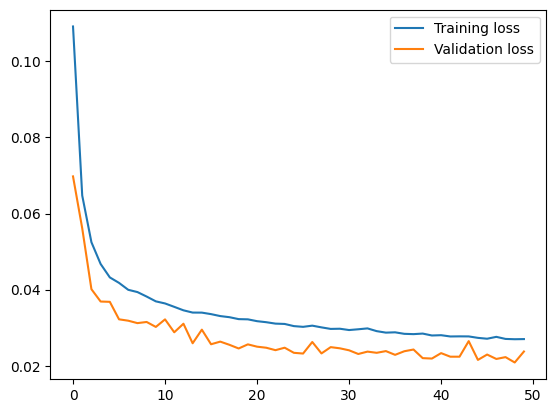

In [34]:
plt.plot(history_BiLSTM_tuned_second.history['loss'], label='Training loss')
plt.plot(history_BiLSTM_tuned_second.history['val_loss'], label='Validation loss')
plt.legend()

In [35]:
pred_BiLSTM_tuned_second = model_BiLSTM_tuned_second.predict(X_test_second)

53/53 [==============================] - 3s 12ms/step


In [41]:
prediction_copies = np.repeat(pred_BiLSTM_tuned_second, 70, axis=-1)
pred_BiLSTM_tuned_unscaled_second = scaler_second.inverse_transform(prediction_copies)[:,-1]

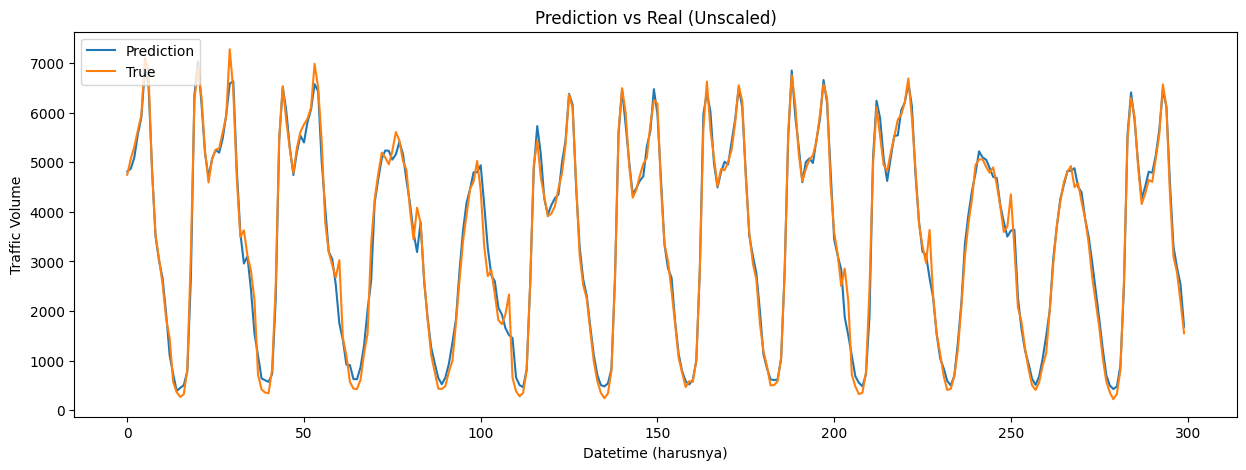

In [42]:
# Plot Prediction vs Real Data
plt.figure(figsize=(15,5))
plt.plot(pred_BiLSTM_tuned_unscaled_second[:300])
plt.plot(true_value_second[:300])
plt.title('Prediction vs Real (Unscaled)')
plt.xlabel('Datetime (harusnya)')
plt.ylabel('Traffic Volume')
plt.legend(['Prediction','True'], loc='upper left')
plt.show()

In [43]:
from sklearn.metrics import mean_absolute_error

mae_tuned_BiLSTM_second = mean_absolute_error(pred_BiLSTM_tuned_unscaled_second, true_value_second)
print(mae_tuned_BiLSTM_second)

172.72071040739903


# GRU

In [9]:
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.models import Sequential
from kerastuner.tuners import RandomSearch

C:\Users\Naufal\AppData\Local\Temp\ipykernel_4152\3460425042.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## First Half Dataset

In [10]:
def build_model_GRU_first(hp):
    model = Sequential()
    model.add(GRU(hp.Int('units_layer1', min_value=32, max_value=128, step=32),
                   activation=hp.Choice('activation', values=['relu', 'tanh']),
                   input_shape=(trainX_first.shape[1], trainX_first.shape[2]),
                   return_sequences=True))
    model.add(GRU(hp.Int('units_layer2', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(trainY_first.shape[1]))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
                  loss='mae')
    return model

In [29]:
tuner_GRU = RandomSearch(
    build_model_GRU_first,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='/model/GRU_first',
    project_name='GRU_tuning_first'
)

tuner_GRU.search(X_train_first, y_train_first, epochs=10, validation_data=(X_test_first, y_test_first))

Trial 10 Complete [00h 03m 49s]
val_loss: 0.052021536976099014

Best val_loss So Far: 0.04163867607712746
Total elapsed time: 00h 43m 02s


In [30]:
# Get the optimal hyperparameters
best_hps_GRU_first = tuner_GRU.get_best_hyperparameters(num_trials=1)[0]

for param in best_hps_GRU_first.values:
    print(param, best_hps_GRU_first.get(param))

units_layer1 64
activation relu
units_layer2 64
dropout 0.5
optimizer adam


In [31]:
# Build the model with the best hyperparameters
model_GRU_tuned_first = tuner_GRU.hypermodel.build(best_hps_GRU_first)
history_GRU_tuned_first = model_GRU_tuned_first.fit(trainX_first, trainY_first, epochs=50, validation_data=(X_test_first, y_test_first))

Epoch 1/50
506/506 [==============================] - 13s 19ms/step - loss: 0.1363 - val_loss: 0.0687
Epoch 2/50
506/506 [==============================] - 10s 19ms/step - loss: 0.0893 - val_loss: 0.0580
Epoch 3/50
506/506 [==============================] - 9s 18ms/step - loss: 0.0790 - val_loss: 0.0495
Epoch 4/50
506/506 [==============================] - 9s 18ms/step - loss: 0.0748 - val_loss: 0.0508
Epoch 5/50
506/506 [==============================] - 9s 18ms/step - loss: 0.0722 - val_loss: 0.0515
Epoch 6/50
506/506 [==============================] - 10s 19ms/step - loss: 0.0707 - val_loss: 0.0436
Epoch 7/50
506/506 [==============================] - 10s 20ms/step - loss: 0.0694 - val_loss: 0.0460
Epoch 8/50
506/506 [==============================] - 10s 21ms/step - loss: 0.0681 - val_loss: 0.0428
Epoch 9/50
506/506 [==============================] - 10s 19ms/step - loss: 0.0670 - val_loss: 0.0420
Epoch 10/50
506/506 [==============================] - 9s 19ms/step - loss: 0.0659 - 

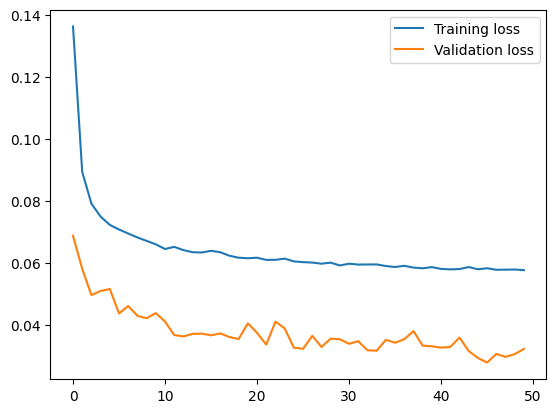

In [32]:
plt.plot(history_GRU_tuned_first.history['loss'], label='Training loss')
plt.plot(history_GRU_tuned_first.history['val_loss'], label='Validation loss')
plt.legend()

In [33]:
pred_GRU_tuned_first = model_GRU_tuned_first.predict(X_test_first)

51/51 [==============================] - 1s 7ms/step


In [34]:
prediction_copies = np.repeat(pred_GRU_tuned_first, 70, axis=-1)
pred_GRU_tuned_unscaled_first = scaler_first.inverse_transform(prediction_copies)[:,-1]

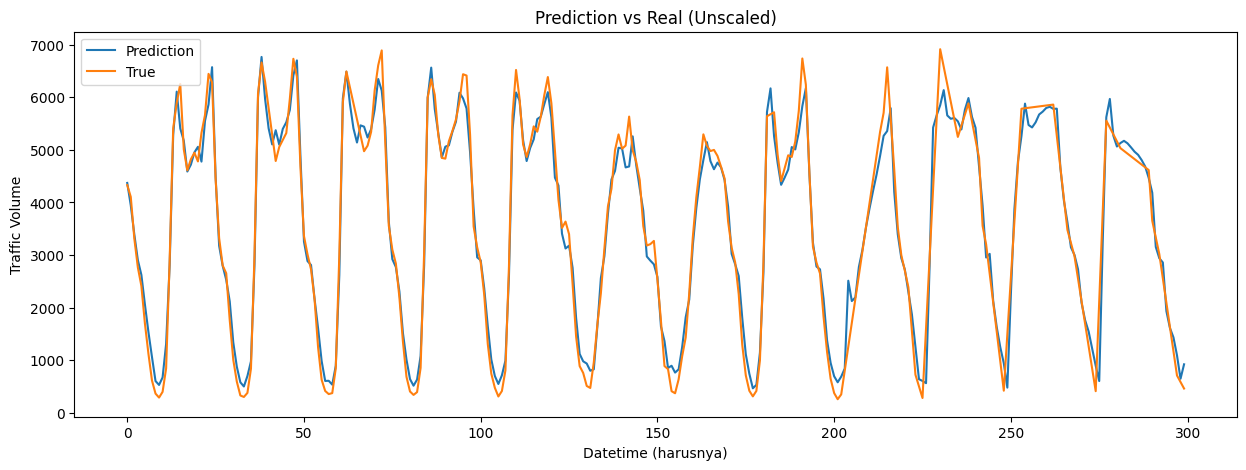

In [35]:
# Plot Prediction vs Real Data
plt.figure(figsize=(15,5))
plt.plot(pred_GRU_tuned_unscaled_first[:300])
plt.plot(true_value_first[:300])
plt.title('Prediction vs Real (Unscaled)')
plt.xlabel('Datetime (harusnya)')
plt.ylabel('Traffic Volume')
plt.legend(['Prediction','True'], loc='upper left')
plt.show()

In [36]:
from sklearn.metrics import mean_absolute_error

mae_tuned_GRU = mean_absolute_error(pred_GRU_tuned_unscaled_first, true_value_first)
print(mae_tuned_GRU)

227.8219236997738


## Second Half Dataset

In [25]:
def build_model_GRU_second(hp):
    model = Sequential()
    model.add(GRU(hp.Int('units_layer1', min_value=32, max_value=128, step=32),
                   activation=hp.Choice('activation', values=['relu', 'tanh']),
                   input_shape=(trainX_second.shape[1], trainX_second.shape[2]),
                   return_sequences=True))
    model.add(GRU(hp.Int('units_layer2', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(trainY_second.shape[1]))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
                  loss='mae')
    return model

In [37]:
tuner_GRU_second = RandomSearch(
    build_model_GRU_second,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='model/GRU_second',
    project_name='GRU_tuning_second'
)

tuner_GRU_second.search(X_train_second, y_train_second, epochs=10, validation_data=(X_test_second, y_test_second))

Trial 10 Complete [00h 04m 00s]
val_loss: 0.061126720160245895

Best val_loss So Far: 0.03147762827575207
Total elapsed time: 00h 53m 26s


In [38]:
# Get the optimal hyperparameters
best_hps_GRU_second = tuner_GRU.get_best_hyperparameters(num_trials=1)[0]

for param in best_hps_GRU_second.values:
    print(param, best_hps_GRU_second.get(param))

units_layer1 64
activation relu
units_layer2 64
dropout 0.5
optimizer adam


In [39]:
# Build the model with the best hyperparameters
model_GRU_tuned_second = tuner_GRU.hypermodel.build(best_hps_GRU_second)
history_GRU_tuned_second = model_GRU_tuned_second.fit(trainX_second, trainY_second, epochs=50, validation_data=(X_test_second, y_test_second))

Epoch 1/50
529/529 [==============================] - 16s 23ms/step - loss: 0.1268 - val_loss: 0.0630
Epoch 2/50
529/529 [==============================] - 12s 22ms/step - loss: 0.0810 - val_loss: 0.0541
Epoch 3/50
529/529 [==============================] - 12s 22ms/step - loss: 0.0713 - val_loss: 0.0507
Epoch 4/50
529/529 [==============================] - 12s 22ms/step - loss: 0.0666 - val_loss: 0.0449
Epoch 5/50
529/529 [==============================] - 11s 22ms/step - loss: 0.0640 - val_loss: 0.0401
Epoch 6/50
529/529 [==============================] - 12s 22ms/step - loss: 0.0631 - val_loss: 0.0418
Epoch 7/50
529/529 [==============================] - 12s 22ms/step - loss: 0.0607 - val_loss: 0.0443
Epoch 8/50
529/529 [==============================] - 12s 22ms/step - loss: 0.0609 - val_loss: 0.0461
Epoch 9/50
529/529 [==============================] - 12s 22ms/step - loss: 0.0598 - val_loss: 0.0475
Epoch 10/50
529/529 [==============================] - 12s 22ms/step - loss: 0.059

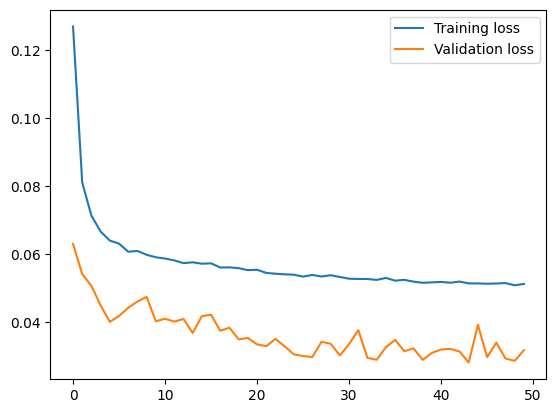

In [40]:
plt.plot(history_GRU_tuned_second.history['loss'], label='Training loss')
plt.plot(history_GRU_tuned_second.history['val_loss'], label='Validation loss')
plt.legend()

In [42]:
pred_GRU_tuned_second = model_GRU_tuned_second.predict(X_test_second)

53/53 [==============================] - 0s 7ms/step


In [43]:
prediction_copies = np.repeat(pred_GRU_tuned_second, 70, axis=-1)
pred_GRU_tuned_unscaled_second = scaler_second.inverse_transform(prediction_copies)[:,-1]

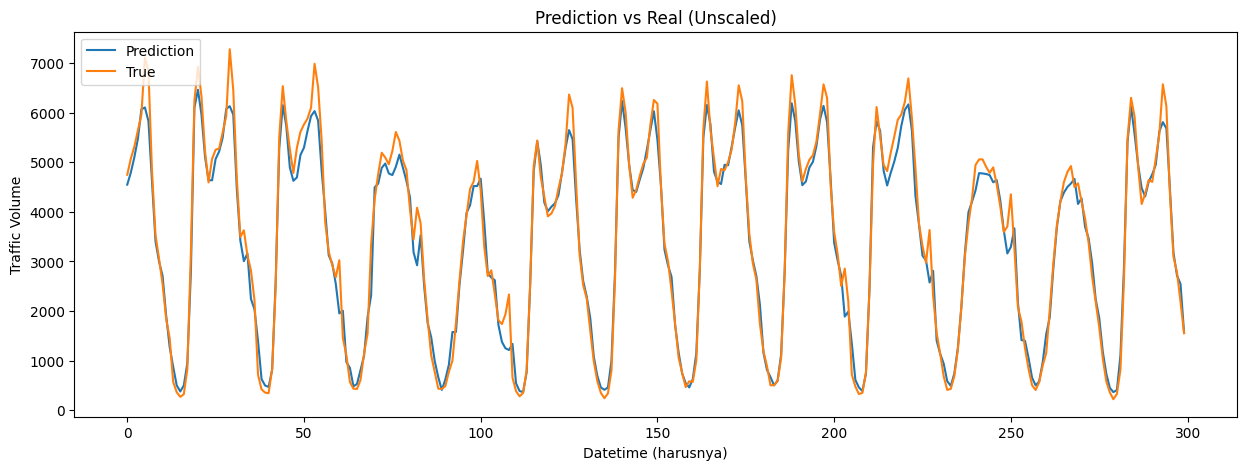

In [44]:
# Plot Prediction vs Real Data
plt.figure(figsize=(15,5))
plt.plot(pred_GRU_tuned_unscaled_second[:300])
plt.plot(true_value_second[:300])
plt.title('Prediction vs Real (Unscaled)')
plt.xlabel('Datetime (harusnya)')
plt.ylabel('Traffic Volume')
plt.legend(['Prediction','True'], loc='upper left')
plt.show()

In [45]:
from sklearn.metrics import mean_absolute_error

mae_tuned_GRU_second = mean_absolute_error(pred_GRU_tuned_unscaled_second, true_value_second)
print(mae_tuned_GRU_second)

231.57351818862077
